# 0. Introduction

The goal of this notebook is to stress different strategies to perform the prediction of the electric consumption over the next 24 hours. 

* Past data extends over one months and a half, with a frequency of one datapoint per 15 min.  

* On the other hand, the climatic temperature is also available as an independent variable for the prediction.

In [ ]:
install.packages('forecast')
library(forecast)
library(ggplot2)
library(xts)
library(readxl)

In [3]:
data <- read_excel("Elec-train.xlsx")
rmse <- function(actual, pred) {
  return(sqrt(mean((actual- pred)^2)))
  } 
data_test = data[4508:dim(data)[1],]
data_train = data[1:4507,]
names(data_train)<-c("Timestamp", "Power", "Temp")

# 1. Series creation: Understanding the data
## 1.1. Importing as xts

15 minute periodicity from 2010-01-01 01:15:00 to 2010-02-07 14:15:00 

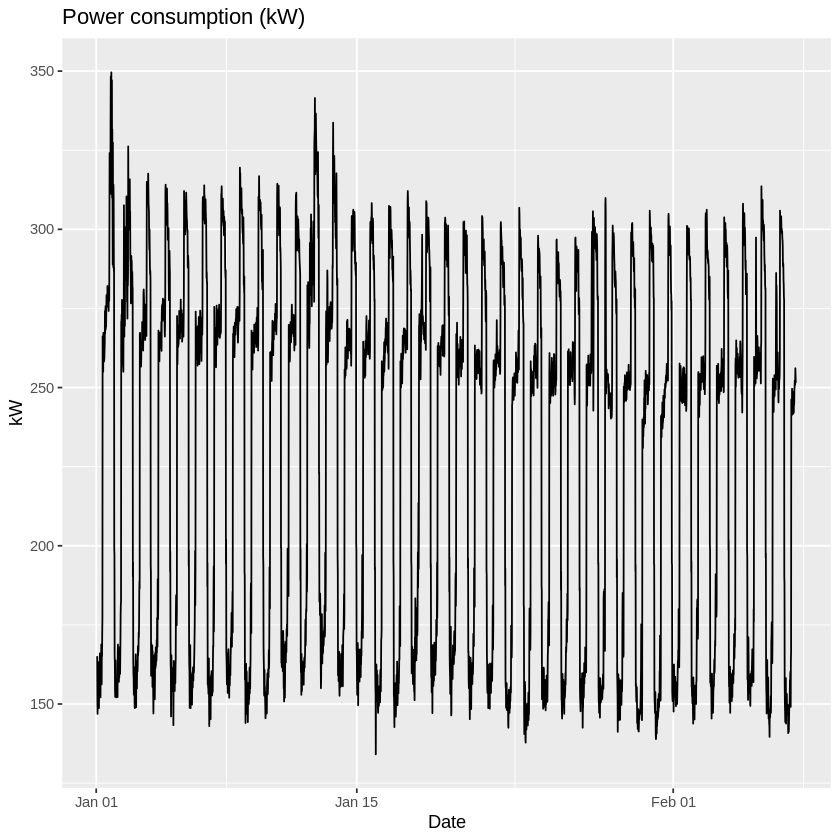

In [4]:
train_to_all_ratio = 0.8
train_cut = as.integer(dim(data_train)[1]*train_to_all_ratio)

elec_train=xts(data_train[1:train_cut,2:3], order.by=as.POSIXlt(data_train$Timestamp[1:train_cut], tz="", format="%m/%d/%Y %H:%M"), frequency = 24*4)
periodicity(elec_train)
elec_val=xts(tail(data_train[,2:3], dim(data_train)[1]-train_cut), order.by=as.POSIXlt(tail(data_train$Timestamp, dim(data_train)[1]-train_cut), tz="", format="%m/%d/%Y %H:%M"))

names(elec_train) <- c("Power", "Temperature")
names(elec_val) <- c("Power", "Temperature")
autoplot(elec_train$'Power') + labs(title="Power consumption (kW)") + labs(x="Date") + labs(y="kW")

xts objects are useful to perform a first evaluation in the series while keeping a time index fully informational in a "%m/%d/%Y %H:%M" format. By inspecting the series, a rational pattern can be seen:

* A minimal power consumption from 23:00 to 8:00, matching classic sleeping time.
* A high consumption between 8:00 and 17:00 aproximately, matching classic working hours.
* An slight increase in the consumption around 17:00, following by a plateau with a smooth decrease until a sharp fall at 23:00. 
This suggest the use of a daily frequency for the creation of the time series (this parameter is critical for a later use of decompose or HoltWinters functions).

### 1.1.2. Evaluating seasonal pattern
One useful way of deeply stressing whether the seasonal pattern is well understood and captured, is to remove it by differentiation from the series and verify that the remaining series is stationary. Starting with the assumed daily seasonal pattern:

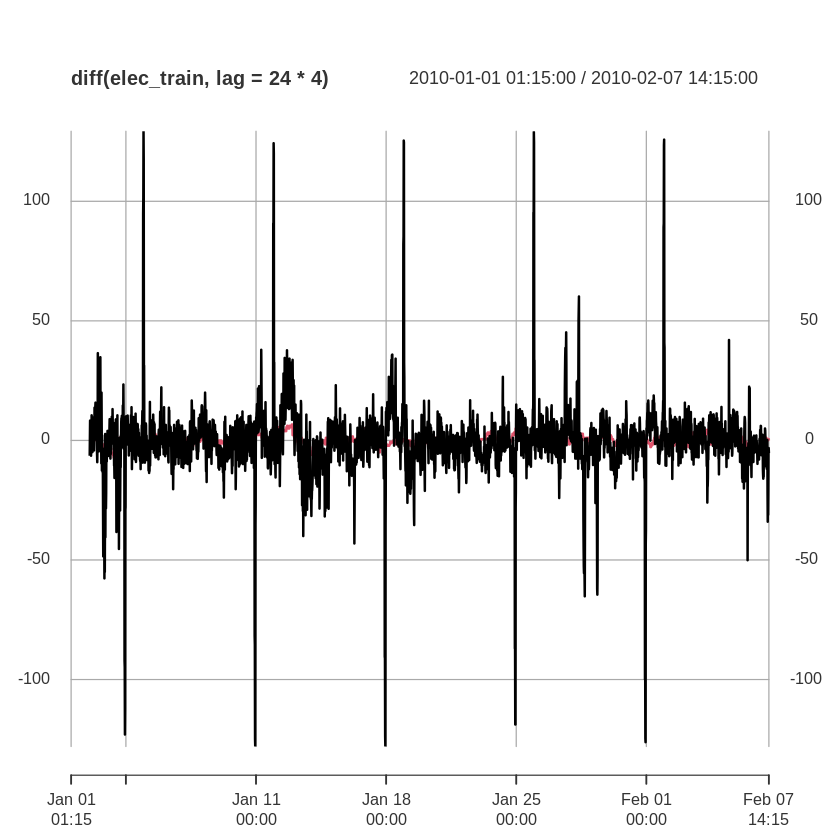

In [5]:
plot(diff(elec_train, lag=24*4))

As it can be seen, most of the seasonal pattern is removed. However, there are two strange peaks taking place every week. These are probably the triplets Saturday-Sunday-Monday. It is also very interesting the weekday peaks on the 28-29 of January, happening inversely (weekday normal consumption, then one abnormally higher day and back to normal again): maybe some event like bank holidays or a general strike? Maybe some reparation works in the building requiring a lot of electricity?

Anyway, what is clear is that the frequency needs to be refined to weekly to capture the sunday variation. This seasonal period is relevant when using decompose and HoltWinters methods, and needs to be hard-typed as the frequency parameter when defining the time series.

## 1.2. As time series
In this snippet the time series are defined, using a 80% of the data as the training set and 20% of the data as the validation set.

In [6]:
train_to_all_ratio = 0.8
train_cut = as.integer(dim(data_train)[1]*train_to_all_ratio)
freq=7*60*24/15
ts_train = ts(data_train[1:train_cut,2], 
              start=c(2010,1),
              frequency = 7*60*24/15)
ts_temp = ts(data_train[1:train_cut,3], 
              start=c(2010,1),
              frequency =7*60*24/15)
starting_period=((length(ts_train)/freq)%%1)*freq+1
ts_val = ts(tail(data_train[,2], dim(data_train)[1]-train_cut), 
              start=c(2015,starting_period),
              frequency = 7*60*24/15)
temp_val = ts(tail(data_train[,3], dim(data_train)[1]-train_cut), 
              start=c(2015,starting_period),
              frequency = 7*60*24/15)


Lastly, and now that the power and the temperature are cast into time series objects, we can try to understand whether the temperature is a relevant factor to be considered in the modeling...

### 1.2.1 Influence of the temperature
One visual way of gaining an intuition of whether the temperature drives some of the not-seasonal variation (specifically, differences between days) is to filter out the seasonal signal from both the temperature and the power series and compare the trend. To enable a visual comparison, both series are standardized before plotting:

integer(0)

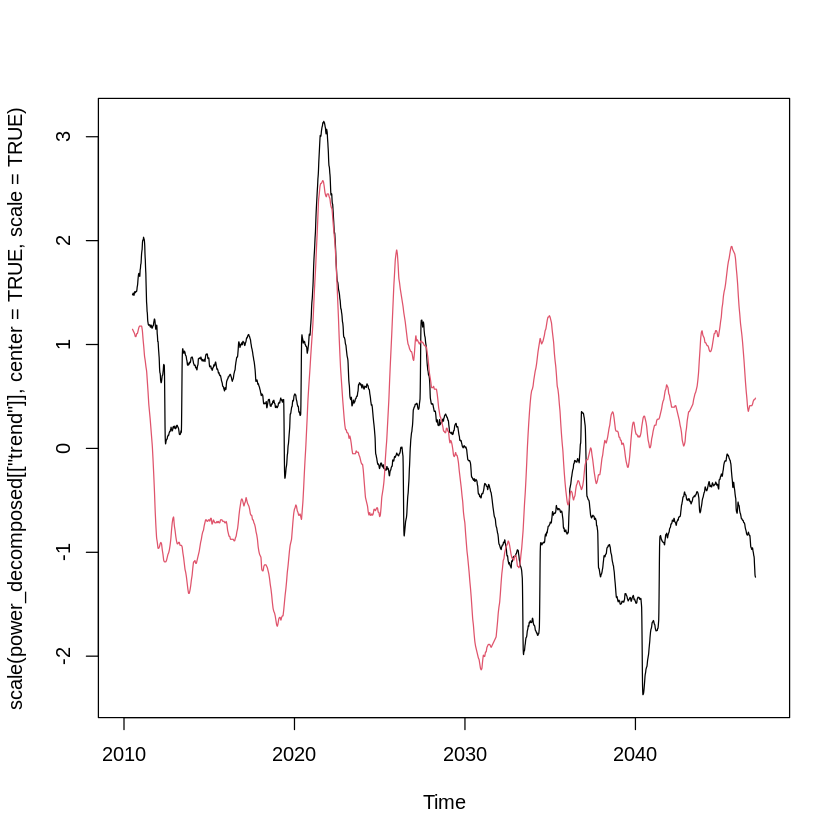

In [7]:
ts_train_weekly = ts(data_train[1:train_cut,2], 
              start=c(2010,1),
              frequency = 60*24/15)
ts_temp_weekly = ts(data_train[1:train_cut,3], 
              start=c(2010,1),
              frequency =60*24/15)

power_decomposed=decompose(ts_train_weekly, type="additive")
temp_decomposed=decompose(ts_temp_weekly, type="additive")
plot(scale(power_decomposed[["trend"]], center = TRUE, scale=TRUE)) + lines(scale(temp_decomposed[["trend"]], scale = TRUE, center = TRUE), col=2)

As it can be seen, the temperature drives indeed some of the variation, although there are a couple of peaks that are not coincident or only in one of the two series. Nevertheless, this graph suggests that including the temperature variable in the model might be interesting to increase its accuracy.

# 2. Modelling based on past consumption
In this section different models will be developed for the forecast of the power consumption based only on the past consumption.
## 2.1. Modeling with exponential smoothing

### 2.1.1 Additive seasonal Holt-Winters

Starting with an additive seasonal Holt-Winters model, motivated by the fact that the time series is clearly (weekly) seasonal with an apparently constant oscillating amplitude. When the prediction for the validation period is compared against the actual validation time series, it can be appreciated a decent matching as shown in the graph below.

integer(0)

[1] 13.99209

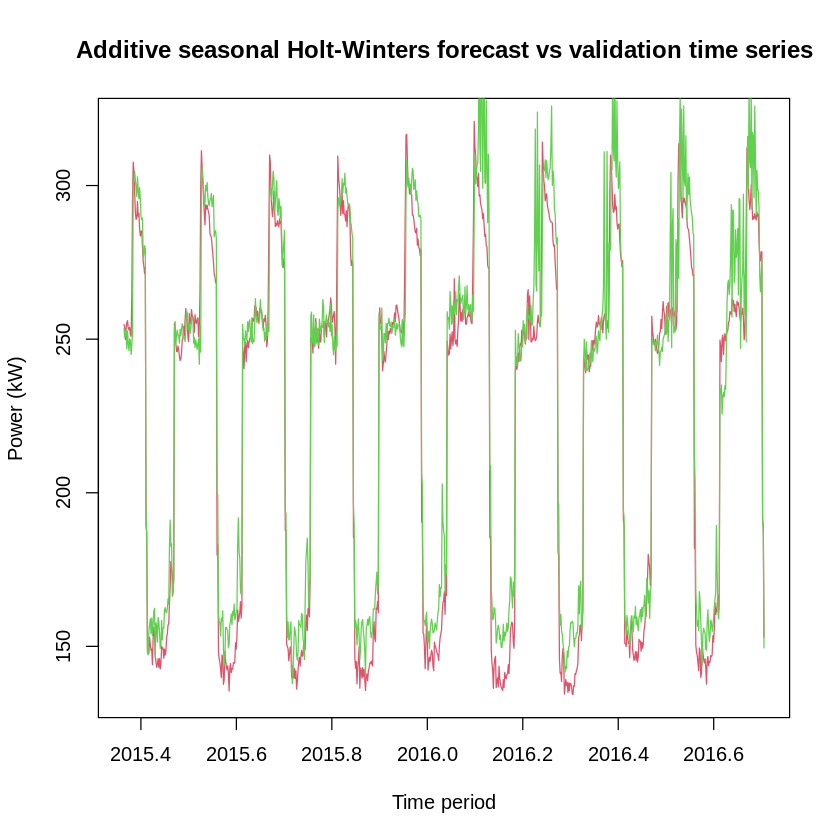

In [8]:
LES=HoltWinters(ts_train, alpha=NULL, beta=NULL, gamma=NULL)
LES_p<-predict(LES, n.ahead=902)

plot(LES_p, col=2, xlab='Time period', ylab='Power (kW)')+lines(ts_val, col=3) + title(main='Additive seasonal Holt-Winters forecast vs validation time series')
rmse(ts_val, LES_p)

The RMSE for the validation interval was 13.99.

## 2.2 ARIMA model
Before removing the deterministic components of the time series (trend and seasonal component) it is useful to have a visual intuition of their morphology. This is shown in the graph below. As it can be seen and stated above, the season amplitude ("vertical variation") and period duration seem both of them constant.
Interestingly, a slightly decreasing trend can be perceived (winter is going away?) and some periodicity can be perceived in the remainders (this will be addressed).

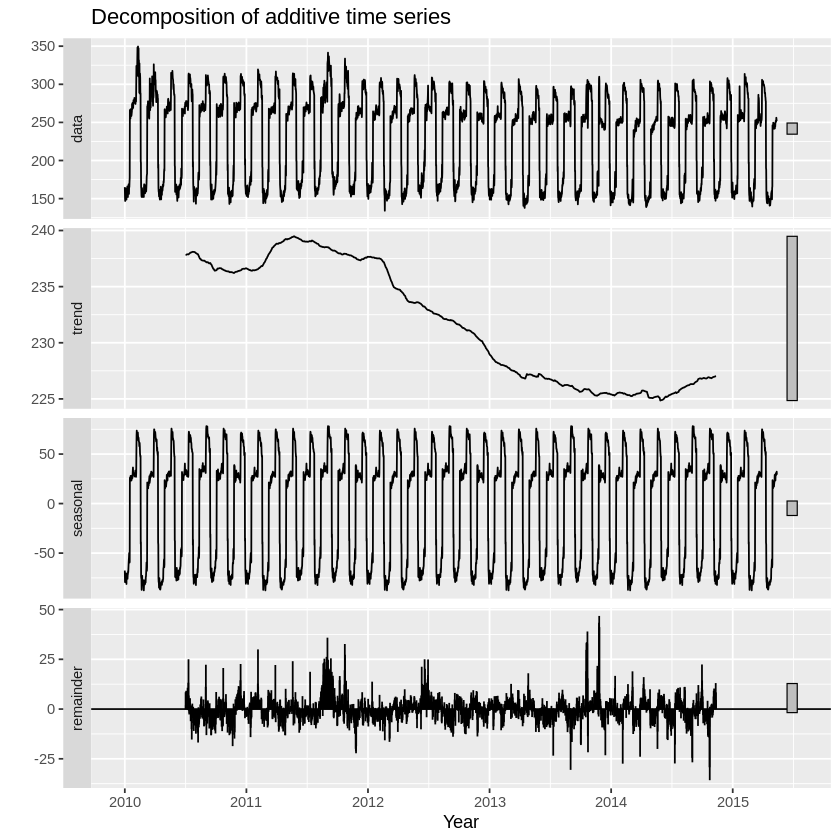

In [9]:
autoplot(decompose(ts_train, type="additive"))+xlab('Year')

To try to obtain an stationary time series the train sample was differentiated with a seasonal lag (weekly, 672 periods) and with a unit lag to remove the trend. A second seasonal differentiating was used to remove some significant autocorrelation remaining with a daily period. However, there is still a strong weekly autocorrelation that could not be removed, so it will be modelised in the SARIMA model by a order 1 seasonal MA.

Just to toy around, the decomposition fo the differentiated series was plotted to gain a visual intuition of any trend or seasonality remaining. Only the weekly seasonal trend is still perceivable.

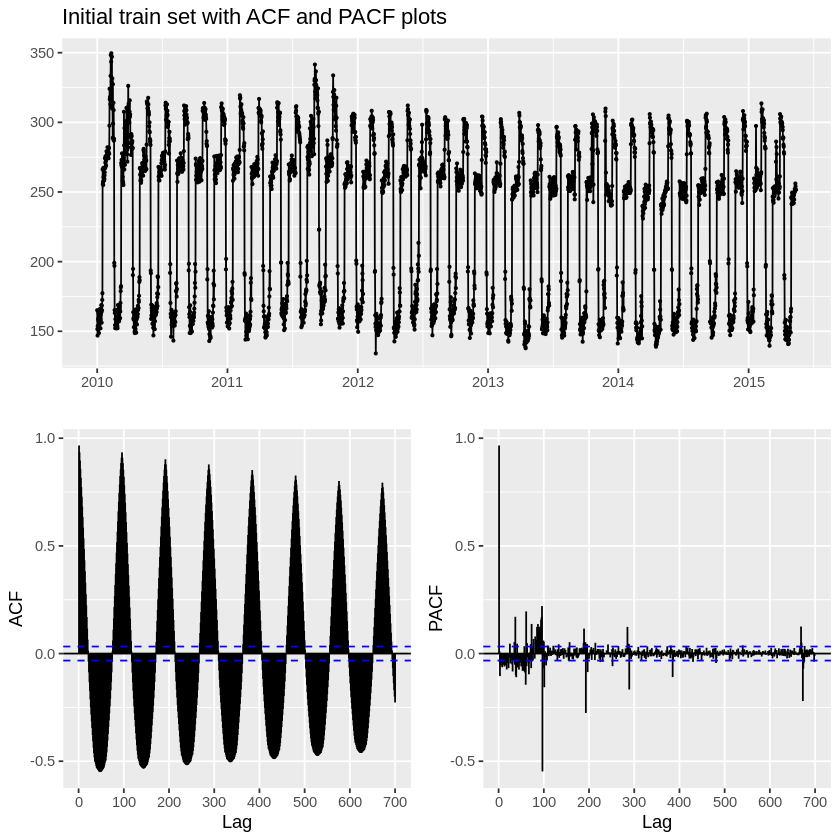

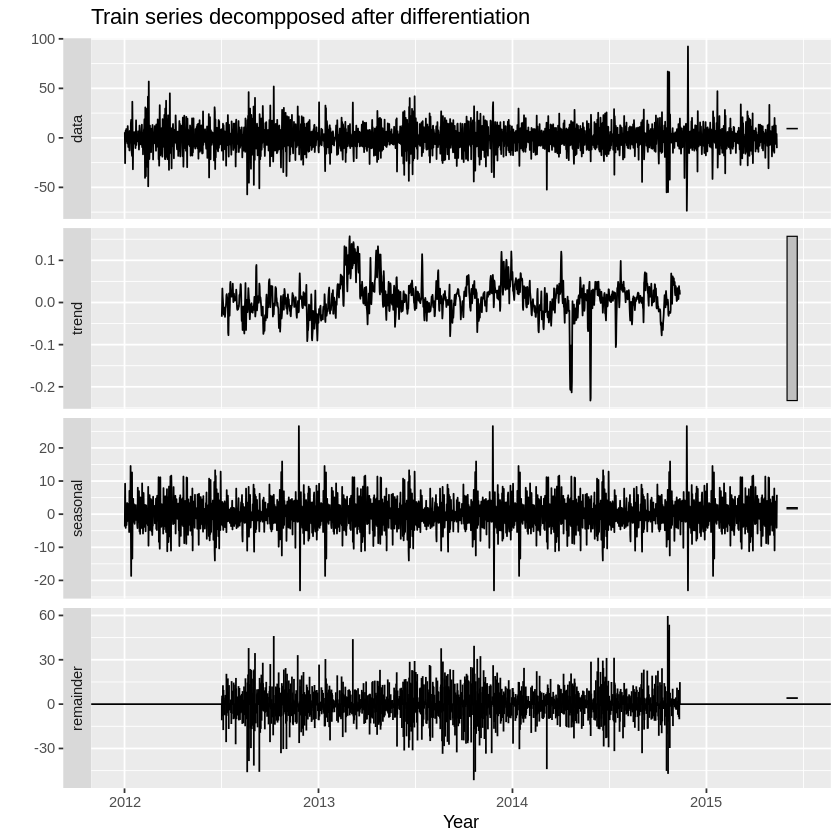

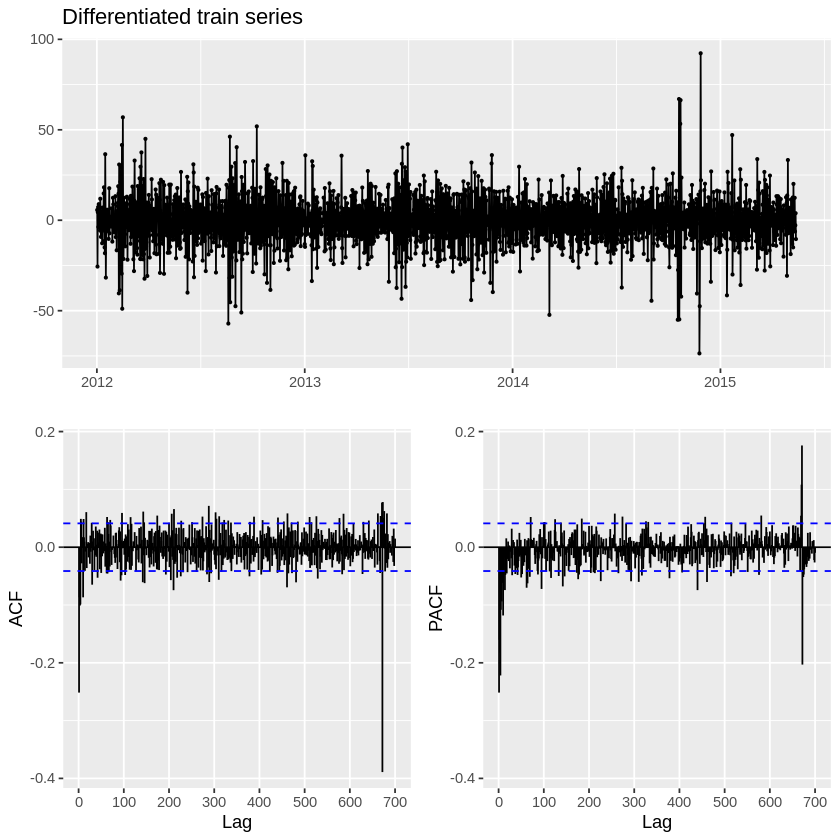

In [10]:
ts_train %>% ggtsdisplay(lag.max = 700, main='Initial train set with ACF and PACF plots')
ts_deseasonal <- ts_train %>% diff(lag=24*4*7, differences=2) 

ts_deseasonal <- ts_deseasonal %>% diff(differences=1) 
autoplot(decompose(ts_deseasonal, type="additive"), main='Train series decompposed after differentiation')+xlab('Year')

ts_deseasonal %>% ggtsdisplay(lag.max = 700, main='Differentiated train series')

Sadly the forecast package does not allow to include a seasonal component with a period higher than 350 in the SARIMA model due to computational reasons. Two workarounds will be used to tackle this issue. Still, just as an informative playaround an auto.arima was run in the differentiated train set. The Ljung-Box test shows that the residuals are significantly far from whiteness, as expected (ACF at period 672 is too remarkable). 

Series: ts_deseasonal 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.4853  -0.9072
s.e.  0.0267   0.0142

sigma^2 estimated as 138.4:  log likelihood=-8776.99
AIC=17559.99   AICc=17560   BIC=17577.16

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE          ACF1
Training set 0.03125401 11.75762 8.664508 NaN  Inf 0.5062415 -0.0008723344

	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with zero mean
Q* = 687.39, df = 450, p-value = 3.479e-12

Model df: 2.   Total lags used: 452



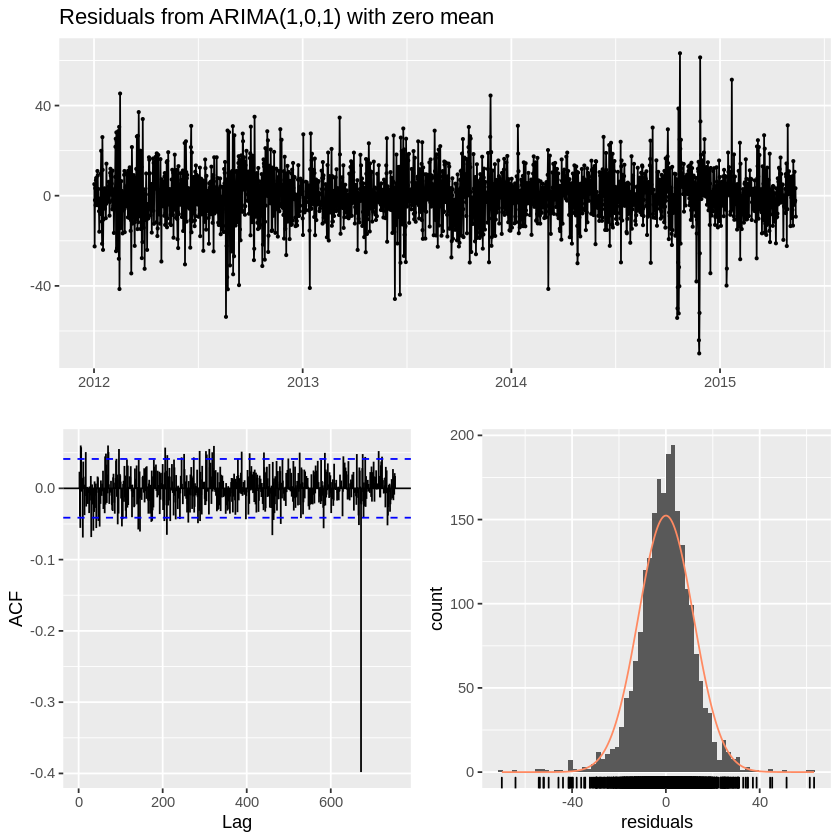

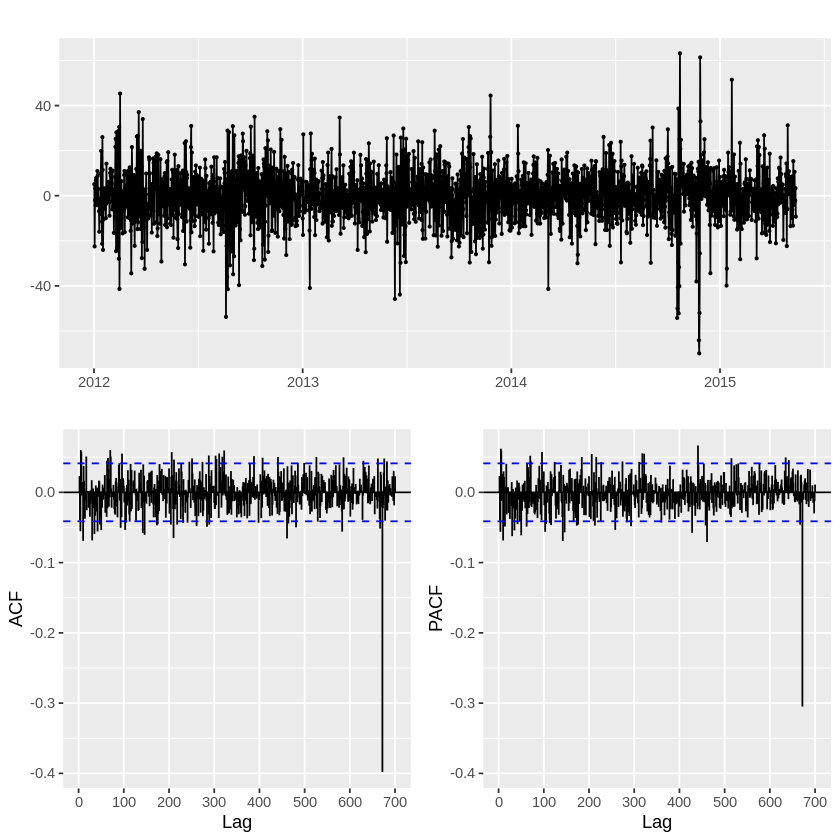

In [11]:
autofit_deseasonal = auto.arima(ts_deseasonal, seasonal=FALSE)
summary(autofit_deseasonal)
checkresiduals(autofit_deseasonal)
autofit_deseasonal %>% residuals() %>% ggtsdisplay(lag.max=700)


The issue pointed out above is clearly identified by the creator and copyright holder of the forecast package https://robjhyndman.com/hyndsight/longseasonality/ . To workaround the incapacity of the package to handle long seasonal SARIMA models, the proposed strategy is to fit the seasonality of the time series with a Fourier series and use it as an exogenous regressor in a standard ARIMA model. This is the method followed hereunder. A gridsearch is carried out with a search range of (0-3) for each one of the parameters in the ARIMA model.

In [12]:
for (p in 0:3) {
  for (d in 0:3) {
    for (q in 0:3){
      fourier_fit = Arima(ts_train, order=c(p,d,q), xreg=fourier(ts_train, K=40))
      fourier_p<-forecast(fourier_fit, h=902, xreg=fourier(ts_train, K=40, h=902))
      error = rmse(ts_val, fourier_p$mean)
      cat('The RMSE for an ARIMA (',p,',',d,',',q,') is:',error,'\n')

    }}}

Results are not shown above due to the time it takes to rerun (they were saved before knitting the original .rmd), but are presented in text below:

The RMSE for an ARIMA ( 0 , 0 , 0 ) is: 16.88703

The RMSE for an ARIMA ( 0 , 0 , 1 ) is: 16.88549

The RMSE for an ARIMA ( 0 , 0 , 2 ) is: 16.8839 

The RMSE for an ARIMA ( 0 , 0 , 3 ) is: 16.88223 

The RMSE for an ARIMA ( 0 , 1 , 0 ) is: 17.77138 

The RMSE for an ARIMA ( 0 , 1 , 1 ) is: 17.66255 

The RMSE for an ARIMA ( 0 , 1 , 2 ) is: 16.89183 

The RMSE for an ARIMA ( 0 , 1 , 3 ) is: 16.78554 

The RMSE for an ARIMA ( 0 , 2 , 0 ) is: 596.7691 

The RMSE for an ARIMA ( 0 , 2 , 1 ) is: 19.58943 

The RMSE for an ARIMA ( 0 , 2 , 2 ) is: 19.18795 

The RMSE for an ARIMA ( 0 , 2 , 3 ) is: 23.24842 

The RMSE for an ARIMA ( 0 , 3 , 0 ) is: 375240.9 

The RMSE for an ARIMA ( 0 , 3 , 1 ) is: 10579.75 

The RMSE for an ARIMA ( 0 , 3 , 2 ) is: 39173.08 

The RMSE for an ARIMA ( 0 , 3 , 3 ) is: 176883.1 

The RMSE for an ARIMA ( 1 , 0 , 0 ) is: 16.87697 

The RMSE for an ARIMA ( 1 , 0 , 1 ) is: 16.87747 

The RMSE for an ARIMA ( 1 , 0 , 2 ) is: 16.87985 

The RMSE for an ARIMA ( 1 , 0 , 3 ) is: 16.88048 

The RMSE for an ARIMA ( 1 , 1 , 0 ) is: 17.73102 

The RMSE for an ARIMA ( 1 , 1 , 1 ) is: 16.75994 

The RMSE for an ARIMA ( 1 , 1 , 2 ) is: 16.76179 

The RMSE for an ARIMA ( 1 , 1 , 3 ) is: 16.7648 

The RMSE for an ARIMA ( 1 , 2 , 0 ) is: 943.3237 

The RMSE for an ARIMA ( 1 , 2 , 1 ) is: 25.18599 

The RMSE for an ARIMA ( 1 , 2 , 2 ) is: 76.7794 

The RMSE for an ARIMA ( 1 , 2 , 3 ) is: 20.59331 

The RMSE for an ARIMA ( 1 , 3 , 0 ) is: 242518.2 

The RMSE for an ARIMA ( 1 , 3 , 1 ) is: 14260.64 

The RMSE for an ARIMA ( 1 , 3 , 2 ) is: 113465.7 

The RMSE for an ARIMA ( 1 , 3 , 3 ) is: 147749.5 

The RMSE for an ARIMA ( 2 , 0 , 0 ) is: 16.87771 

The RMSE for an ARIMA ( 2 , 0 , 1 ) is: 16.87641 

The RMSE for an ARIMA ( 2 , 0 , 2 ) is: 16.88458 

The RMSE for an ARIMA ( 2 , 0 , 3 ) is: 16.88443 

The RMSE for an ARIMA ( 2 , 1 , 0 ) is: 17.64655 

The RMSE for an ARIMA ( 2 , 1 , 1 ) is: 16.76325 

The RMSE for an ARIMA ( 2 , 1 , 2 ) is: 16.75991 

The RMSE for an ARIMA ( 2 , 1 , 3 ) is: 18.29587 

The RMSE for an ARIMA ( 2 , 2 , 0 ) is: 969.7599 

The RMSE for an ARIMA ( 2 , 2 , 1 ) is: 19.20146 

The RMSE for an ARIMA ( 2 , 2 , 2 ) is: 24.40081 

The RMSE for an ARIMA ( 2 , 2 , 3 ) is: 23.79382 

The RMSE for an ARIMA ( 2 , 3 , 0 ) is: 622660.5 

The RMSE for an ARIMA ( 2 , 3 , 1 ) is: 7659.549 

The RMSE for an ARIMA ( 2 , 3 , 2 ) is: 22271.11 

The RMSE for an ARIMA ( 2 , 3 , 3 ) is: 35991.83 

The RMSE for an ARIMA ( 3 , 0 , 0 ) is: 16.88226 

The RMSE for an ARIMA ( 3 , 0 , 1 ) is: 16.8848 

The RMSE for an ARIMA ( 3 , 0 , 2 ) is: 16.78233 

The RMSE for an ARIMA ( 3 , 0 , 3 ) is: 16.88464 

The RMSE for an ARIMA ( 3 , 1 , 0 ) is: 17.47939 

The RMSE for an ARIMA ( 3 , 1 , 1 ) is: 16.79463 

The RMSE for an ARIMA ( 3 , 1 , 2 ) is: 18.11329 

As it can be seen, the best result was obtained for a set of parameters of (1,1,1). This model is fitted on the training set and evaluated on the validation set. For the seasonal pattern, the order of the fourier transform can be viewed as an hyperparameter to optimized. As performed before for the ARIMA parameters, a for loop will be used to evaluate this hyperparameter by gridsearch.


In [ ]:
for (fourier_order in 1:100){
  fourier_fit = Arima(ts_train, order=c(1,1,1), xreg=fourier(ts_train, K=fourier_order))
  fourier_p<-forecast(fourier_fit, h=902, xreg=fourier(ts_train, K=fourier_order, h=902))

  fourier_rsme = rmse(ts_val, fourier_p$mean)
    
  cat('The RMSE for an ARIMA with fourier order ',fourier_order,' is:',fourier_rsme,'\n')
}

As before, the results are presented as text because running the chuck takes too long while knitting:

The RMSE for an ARIMA with fourier order  1  is: 60.82287 

The RMSE for an ARIMA with fourier order  2  is: 62.33829 

The RMSE for an ARIMA with fourier order  3  is: 62.57347 

The RMSE for an ARIMA with fourier order  4  is: 62.87534 

The RMSE for an ARIMA with fourier order  5  is: 64.50008 

The RMSE for an ARIMA with fourier order  6  is: 64.45767 

The RMSE for an ARIMA with fourier order  7  is: 44.89816 

The RMSE for an ARIMA with fourier order  8  is: 46.71415 

The RMSE for an ARIMA with fourier order  9  is: 48.42495 

The RMSE for an ARIMA with fourier order  10  is: 49.00857 

The RMSE for an ARIMA with fourier order  11  is: 50.70816 

The RMSE for an ARIMA with fourier order  12  is: 52.15889 

The RMSE for an ARIMA with fourier order  13  is: 53.01607 

The RMSE for an ARIMA with fourier order  14  is: 22.09183 

The RMSE for an ARIMA with fourier order  15  is: 21.96746 

The RMSE for an ARIMA with fourier order  16  is: 21.89996 

The RMSE for an ARIMA with fourier order  17  is: 21.87419 

The RMSE for an ARIMA with fourier order  18  is: 21.83263 

The RMSE for an ARIMA with fourier order  19  is: 21.6768 

The RMSE for an ARIMA with fourier order  20  is: 21.6221 

The RMSE for an ARIMA with fourier order  21  is: 19.50004 

The RMSE for an ARIMA with fourier order  22  is: 19.48934 

The RMSE for an ARIMA with fourier order  23  is: 19.43674 

The RMSE for an ARIMA with fourier order  24  is: 19.35699 

The RMSE for an ARIMA with fourier order  25  is: 19.26611 

The RMSE for an ARIMA with fourier order  26  is: 19.22516 

The RMSE for an ARIMA with fourier order  27  is: 19.21136 

The RMSE for an ARIMA with fourier order  28  is: 17.42813 

The RMSE for an ARIMA with fourier order  29  is: 17.36448 

The RMSE for an ARIMA with fourier order  30  is: 17.29379 

The RMSE for an ARIMA with fourier order  31  is: 17.26931 

The RMSE for an ARIMA with fourier order  32  is: 17.22089 

The RMSE for an ARIMA with fourier order  33  is: 17.20138 

The RMSE for an ARIMA with fourier order  34  is: 17.21454 

The RMSE for an ARIMA with fourier order  35  is: 17.00667 

The RMSE for an ARIMA with fourier order  36  is: 16.95158 

The RMSE for an ARIMA with fourier order  37  is: 16.91653 

The RMSE for an ARIMA with fourier order  38  is: 16.
87632 

The RMSE for an ARIMA with fourier order  39  is: 16.
82886 

The RMSE for an ARIMA with fourier order  40  is: 16.75994 

The RMSE for an ARIMA with fourier order  41  is: 16.73903 

The RMSE for an ARIMA with fourier order  42  is: 16.376 

The RMSE for an ARIMA with fourier order  43  is: 16.35976 

The RMSE for an ARIMA with fourier order  44  is: 16.35097 

The RMSE for an ARIMA with fourier order  45  is: 16.34966 

The RMSE for an ARIMA with fourier order  46  is: 16.33365 

The RMSE for an ARIMA with fourier order  47  is: 16.31225 

The RMSE for an ARIMA with fourier order  48  is: 16.3193 

The RMSE for an ARIMA with fourier order  49  is: 15.42456 

The RMSE for an ARIMA with fourier order  50  is: 15.43435 

The RMSE for an ARIMA with fourier order  51  is: 15.42916 

The RMSE for an ARIMA with fourier order  52  is: 15.43051 

The RMSE for an ARIMA with fourier order  53  is: 15.41862 

The RMSE for an ARIMA with fourier order  54  is: 15.39425 

The RMSE for an ARIMA with fourier order  55  is: 15.36348 

The RMSE for an ARIMA with fourier order  56  is: 15.33897 

The RMSE for an ARIMA with fourier order  57  is: 15.3065 

The RMSE for an ARIMA with fourier order  58  is: 15.27847 

The RMSE for an ARIMA with fourier order  59  is: 15.26554 

The RMSE for an ARIMA with fourier order  60  is: 15.25559 

The RMSE for an ARIMA with fourier order  61  is: 15.22965 

The RMSE for an ARIMA with fourier order  62  is: 15.22358 

The RMSE for an ARIMA with fourier order  63  is: 15.28628 

The RMSE for an ARIMA with fourier order  64  is: 15.26668 

The RMSE for an ARIMA with fourier order  65  is: 15.27593 

The RMSE for an ARIMA with fourier order  66  is: 15.28811 

The RMSE for an ARIMA with fourier order  67  is: 15.27892 

The RMSE for an ARIMA with fourier order  68  is: 15.2853 

The RMSE for an ARIMA with fourier order  69  is: 15.32915 

The RMSE for an ARIMA with fourier order  70  is: 15.41649 

The RMSE for an ARIMA with fourier order  71  is: 15.40514 

The RMSE for an ARIMA with fourier order  72  is: 15.4137 

The RMSE for an ARIMA with fourier order  73  is: 15.40356 

The RMSE for an ARIMA with fourier order  74  is: 15.38304 

The RMSE for an ARIMA with fourier order  75  is: 15.34771 

The RMSE for an ARIMA with fourier order  76  is: 15.32581 

The RMSE for an ARIMA with fourier order  77  is: 15.37724 

The RMSE for an ARIMA with fourier order  78  is: 15.34707 

The RMSE for an ARIMA with fourier order  79  is: 15.33272 

The RMSE for an ARIMA with fourier order  80  is: 15.31757 

The RMSE for an ARIMA with fourier order  81  is: 15.32375 

The RMSE for an ARIMA with fourier order  82  is: 15.32546 

The RMSE for an ARIMA with fourier order  83  is: 15.36219 

The RMSE for an ARIMA with fourier order  84  is: 15.06636 

The RMSE for an ARIMA with fourier order  85  is: 15.09422 

The RMSE for an ARIMA with fourier order  86  is: 15.09553 

The RMSE for an ARIMA with fourier order  87  is: 15.11723 

The RMSE for an ARIMA with fourier order  88  is: 15.14095 

The RMSE for an ARIMA with fourier order  89  is: 15.17668 

The RMSE for an ARIMA with fourier order  90  is: 15.19314 

The RMSE for an ARIMA with fourier order  91  is: 15.41263 

The RMSE for an ARIMA with fourier order  92  is: 15.38278 

The RMSE for an ARIMA with fourier order  93  is: 15.36476 

The RMSE for an ARIMA with fourier order  94  is: 15.35196 

The RMSE for an ARIMA with fourier order  95  is: 15.31078 

The RMSE for an ARIMA with fourier order  96  is: 15.27228 

The RMSE for an ARIMA with fourier order  97  is: 15.25702 

The RMSE for an ARIMA with fourier order  98  is: 15.44931 

The RMSE for an ARIMA with fourier order  99  is: 15.4239 

The RMSE for an ARIMA with fourier order  100  is: 15.40881 

As per the gridsearch above, the order employed will be K = 84.
The graphs below show the agreement between the actual data and the model (fitted series for the training set and forecasted series for the validation set). 
The RMSE for this set up is 15.06.

integer(0)

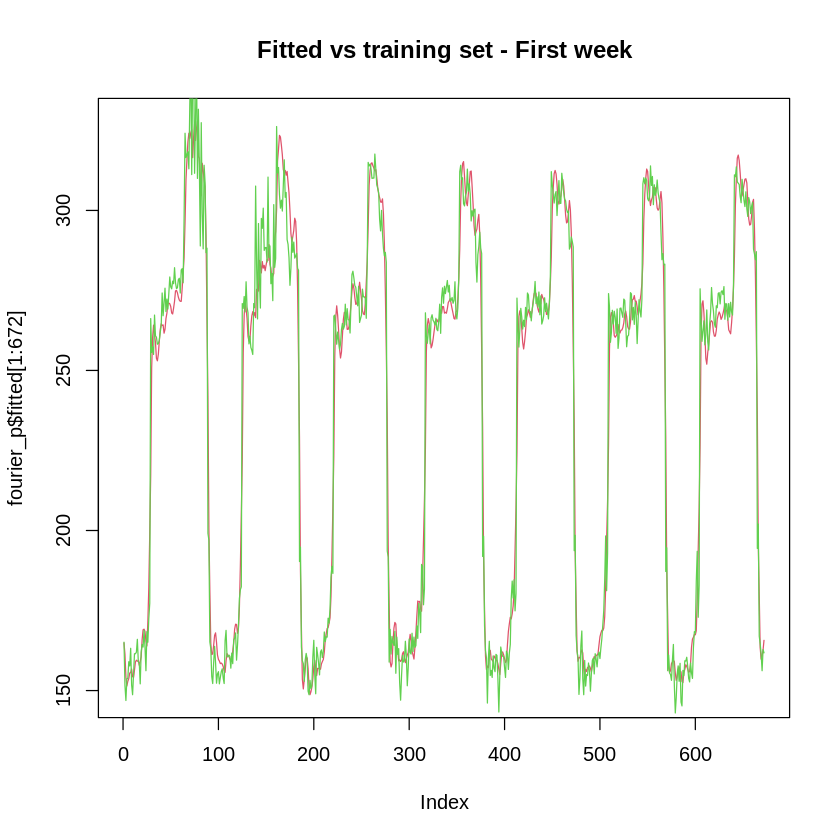

integer(0)

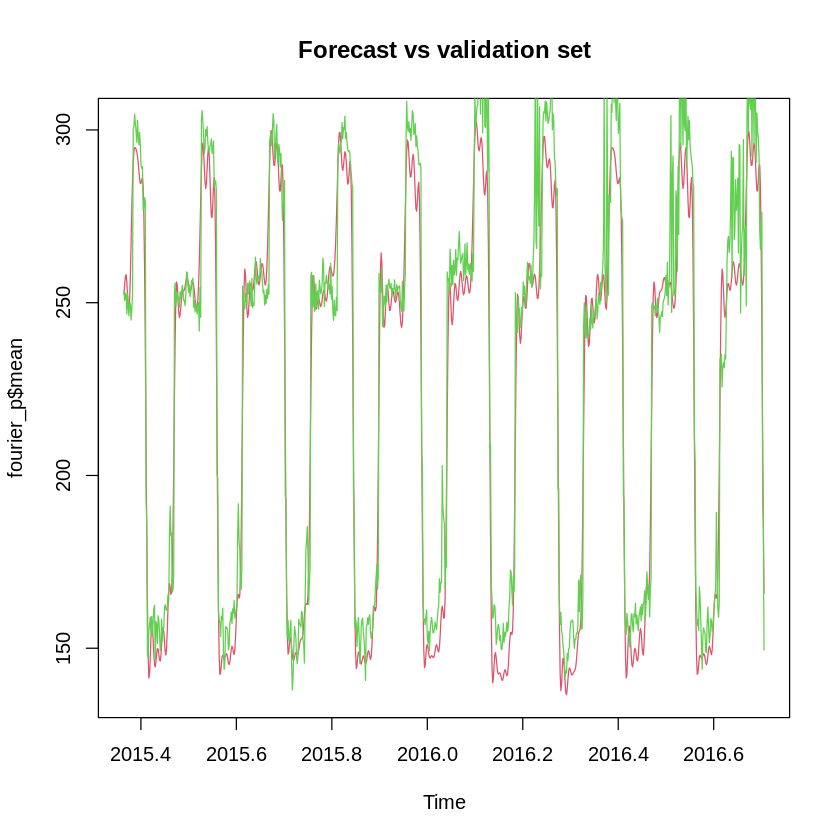

[1] 15.06671

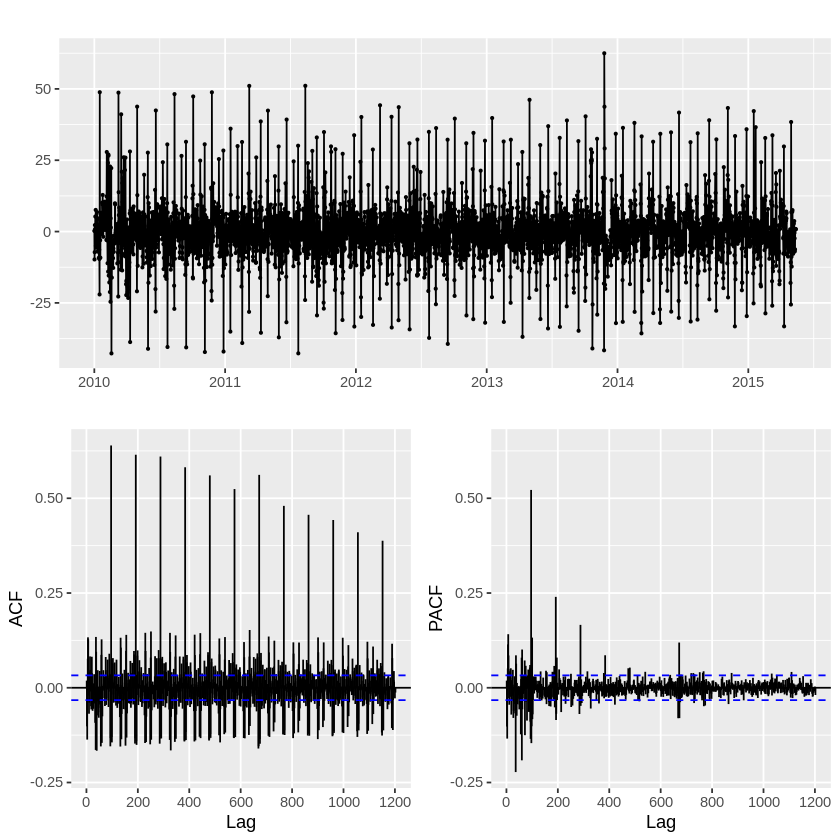

In [13]:
fourier_fit = Arima(ts_train, order=c(1,1,1), xreg=fourier(ts_train, K=84))
fourier_p<-forecast(fourier_fit, h=902, xreg=fourier(ts_train, K=84, h=902))
plot(fourier_p$fitted[1:672], col=2, type='l')+lines(ts_train[1:672], col=3)+title('Fitted vs training set - First week')

plot(fourier_p$mean, col=2)+lines(ts_val, col=3)+title('Forecast vs validation set')

fourier_fit %>% residuals() %>% ggtsdisplay()
rmse(ts_val, fourier_p$mean)

# 3. Modelling including temperature as covariate

## 3.1. ARIMA model with Fourier transform

The temperature might be as well a relevant covariate as discussed earlier in this report. It can be introduced in the model as an exogenous regressor, the same way the fourier transform was used above. In order to be consistent with the approach followed in the previous section, the seasonality of the ARIMA model will be modelled as a Fourier transform. Two exogenous variables will be introduced into the ARIMA model this time, the Fourier transform and the temperature.

We first create the matrix with the exogenous variables.

In [14]:
xreg_train = cbind(fourier(ts_train, K=84), ts_temp)
xreg_val = cbind(fourier(ts_train, K=84, h=902), temp_val)

We follow an analogous procedure as done in the previous section. Again the plots for the agreement between the actual data and the model are presented.

When introducing the temperature in the model the RMSE decreases from 15.06 to 15.01 (not a huge gain).

Warning message in forecast.forecast_ARIMA(fourier_temp_fit, h = 902, xreg = xreg_val):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


integer(0)

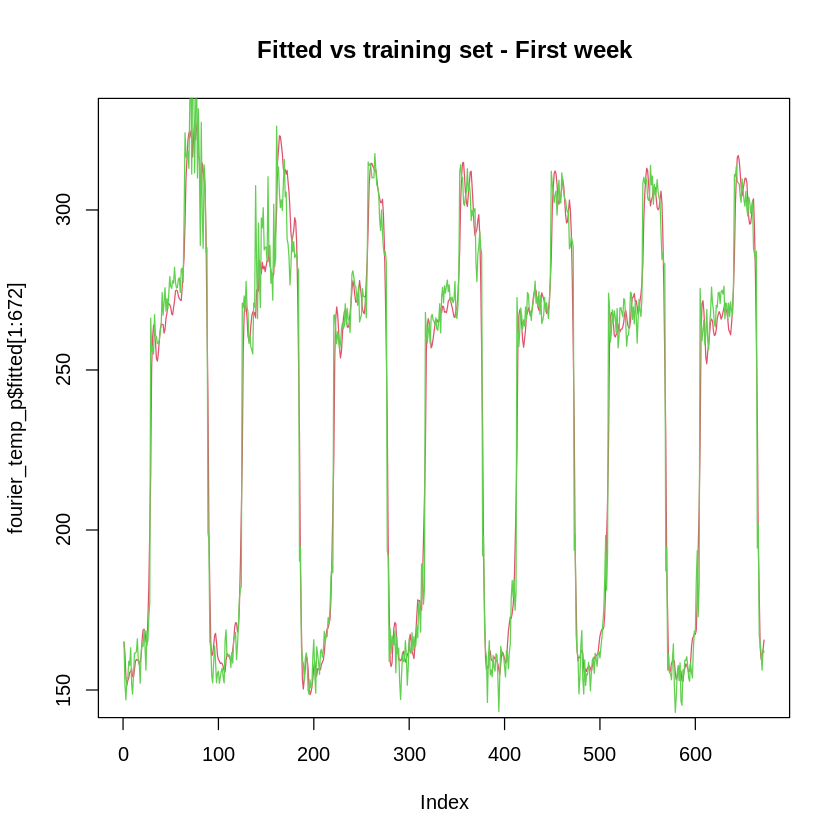

integer(0)

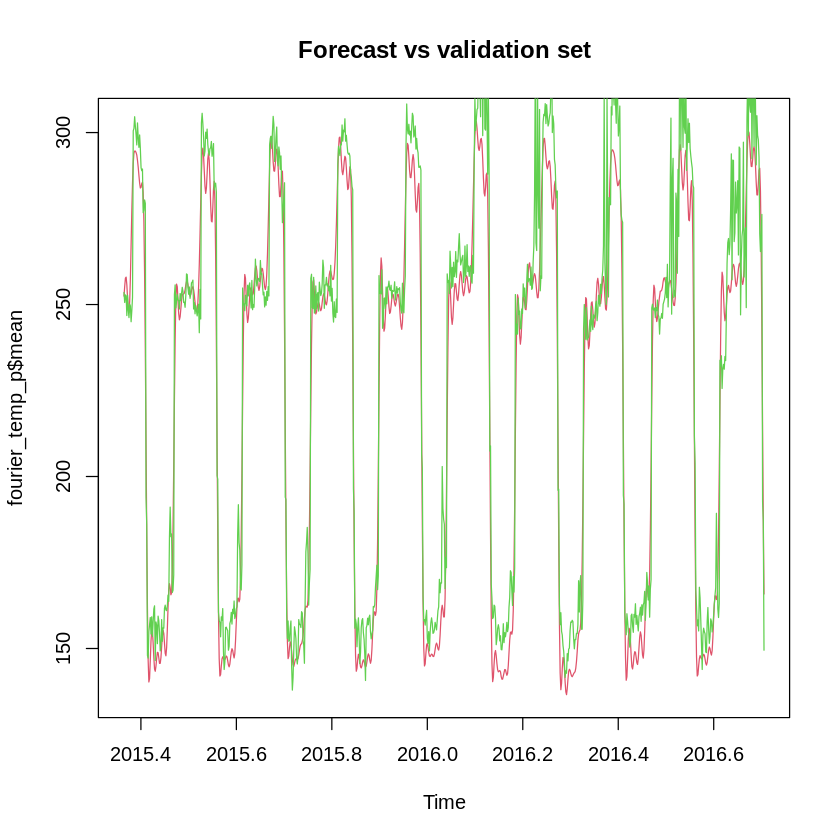

[1] 15.02217

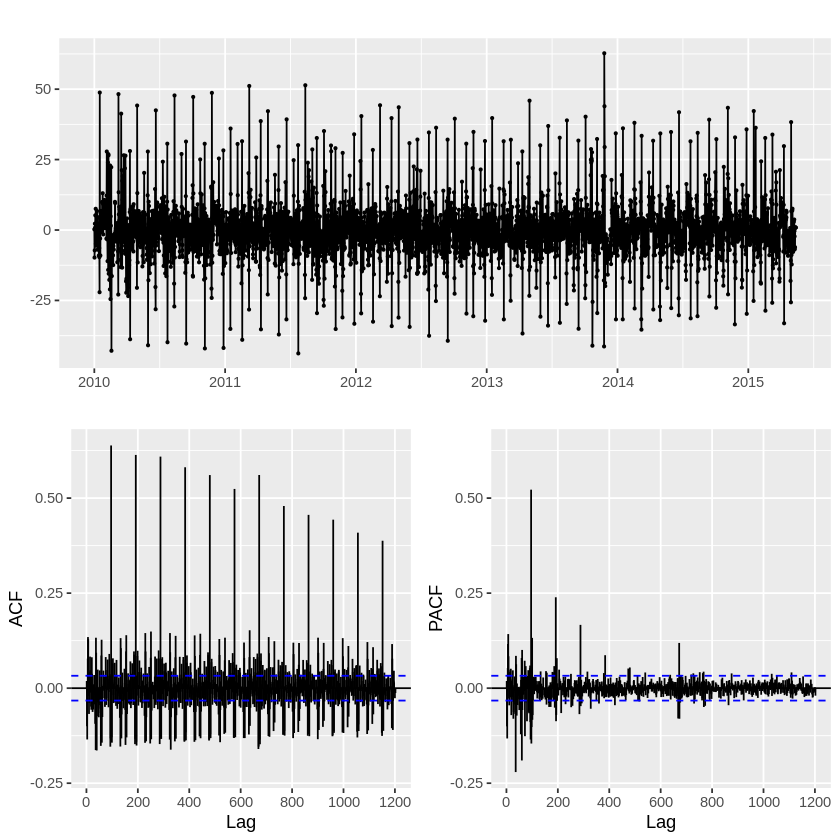

In [15]:
fourier_temp_fit = Arima(ts_train, order=c(1,1,1), xreg = xreg_train)
fourier_temp_p<-forecast(fourier_temp_fit, h=902, xreg = xreg_val)
plot(fourier_temp_p$fitted[1:672], col=2, type='l')+lines(ts_train[1:672], col=3)+title('Fitted vs training set - First week')

plot(fourier_temp_p$mean, col=2)+lines(ts_val, col=3)+title('Forecast vs validation set')

fourier_temp_fit %>% residuals() %>% ggtsdisplay()
rmse(ts_val, fourier_temp_p$mean)


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,1) errors
Q* = 19480, df = 550, p-value < 2.2e-16

Model df: 171.   Total lags used: 721



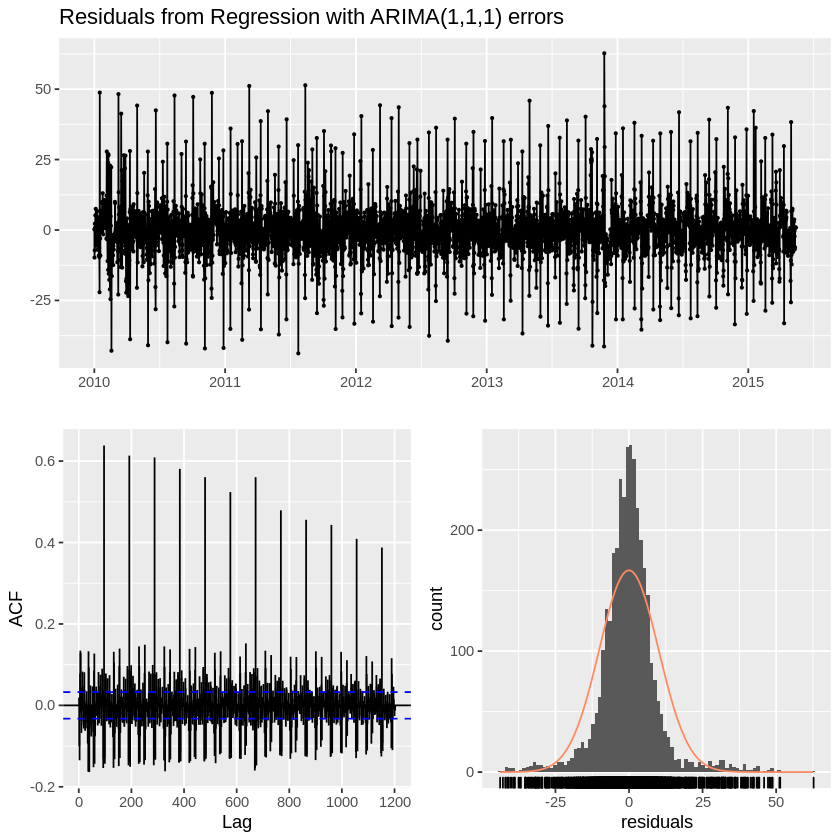

In [16]:
checkresiduals(fourier_temp_fit, test='LB', plot=TRUE)

## 3.2. Linear regression

In order to perform a linear regression with the trend and the season plus the temperature as covariate we need to explicitly reduce the frequency of the time series defined (tslm creates a covariate for each seasonal lag, and the dimensionality of a seasonal frequency of 672 periods (weekly) requires >30GB of RAM to fit the model).

In [17]:

ts_train_day = ts(data_train[1:train_cut,2], 
              start=c(2010,1),
              frequency = 60*24/15)
ts_temp_day = ts(data_train[1:train_cut,3], 
              start=c(2010,1),
              frequency =60*24/15)

ts_val_day = ts(tail(data_train[,2], dim(data_train)[1]-train_cut), 
              start=c(2047, 54),
              frequency = 60*24/15)
temp_val_day = ts(tail(data_train[,3], dim(data_train)[1]-train_cut), 
              start=c(2047, 54),
              frequency = 60*24/15)


The linear regression model is fitted below.

In [18]:
linear_model_fit=tslm(ts_train_day~trend + season + ts_temp_day)


As it can be seen in the residuals below and the Ljung-Box test, the hypothesis that the residuals have not autocorrelation can be rejected. Nevertheless, the RSME of this model is 19.67 so it will be discarded in favour of the ARIMA model with the Fourier transform as covariate.


	Ljung-Box test

data:  Residuals from Linear regression model
Q* = 8438.3, df = 94, p-value < 2.2e-16

Model df: 98.   Total lags used: 192



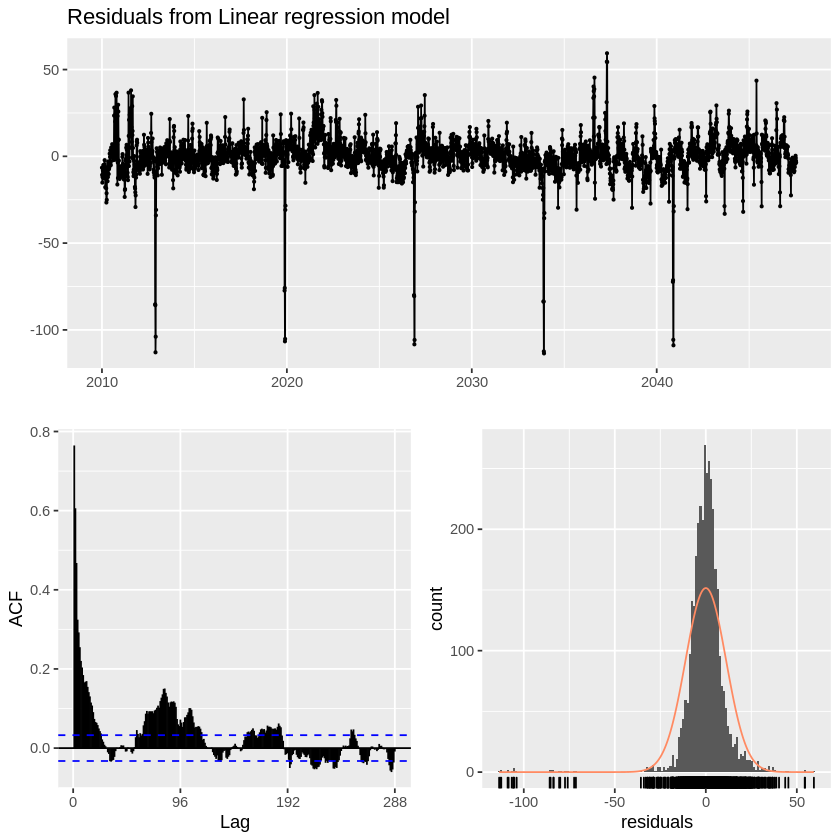

In [19]:
checkresiduals(linear_model_fit, test='LB', plot=TRUE)

In [20]:
lin_model_p = forecast(linear_model_fit, xreg=temp_val_day, h=3605)
rmse(ts_val, lin_model_p$mean[1:902])

[1] 19.67186

## 3.3. Neural network

As an alternative, a feed-forward neural network with one hidden layer will be trained with the training set, to evaluate its performance on the validation set. As it can be seen below, this kind of neural network does reasonably well in predicting the next day consumption, but leads to some unexpected and illogical behavior in the mid run.

integer(0)

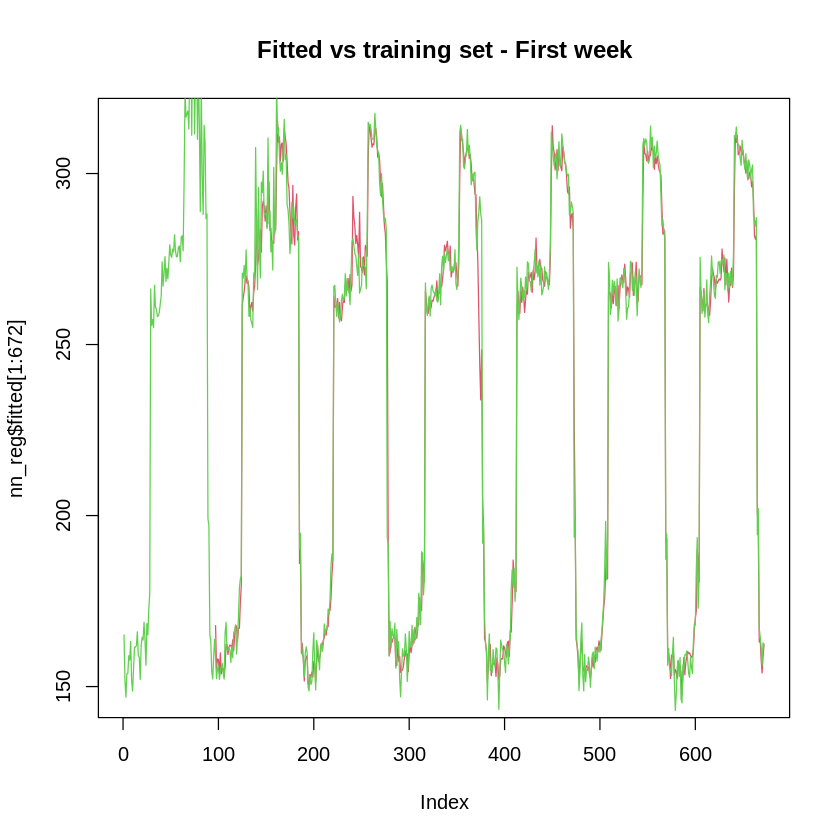

integer(0)

[1] 53.91258

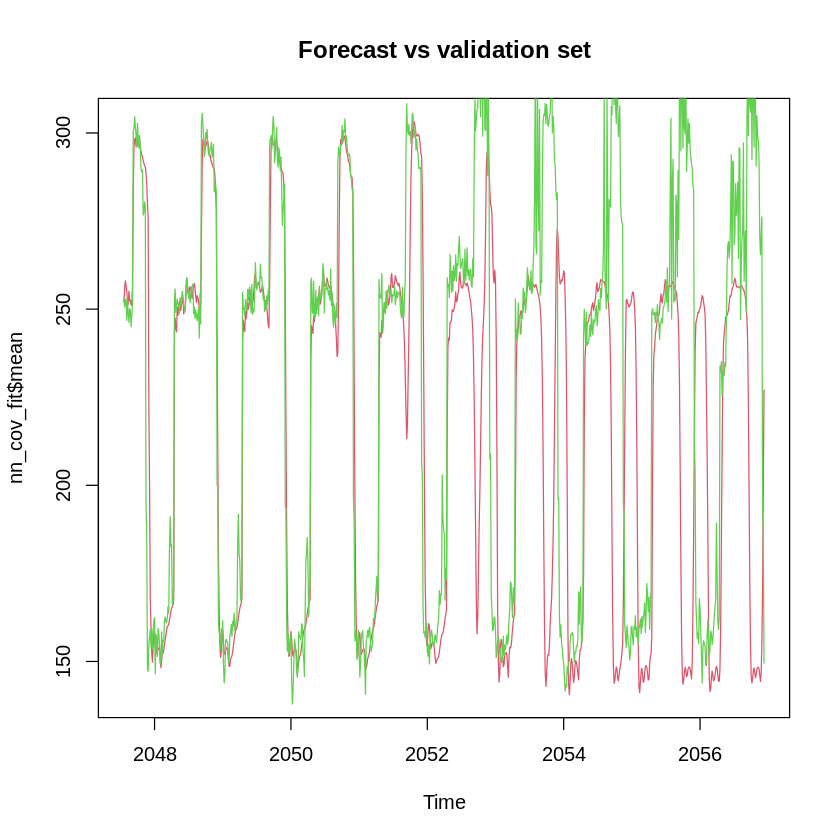

In [21]:
nn_reg=nnetar(ts_train_day,xreg=ts_temp_day)
nn_cov_fit=forecast(nn_reg,h=902,xreg=temp_val_day)

plot(nn_reg$fitted[1:672], col=2, type='l')+lines(ts_train_day[1:672], col=3)+title('Fitted vs training set - First week')

plot(nn_cov_fit$mean, col=2) + lines(ts_val_day, col=3) + title('Forecast vs validation set')

rmse(ts_val_day, nn_cov_fit$mean)

# 4.1 Next-day prediction

Once the different models have been evaluated, the best performing model (basing on the RMSE criterion) will be chosen both for the case when the temperature is used for the forecast and for the case when that is not the case. This two models were:
1. Only using the past consumption: Holt-Winters model with additive seasonal pattern. RSME: 13.99.
2. Using the temperature as covariate: ARIMA model with fourier series as covariate. RSME: 15.01.

The two models will be refitted with all the data available instead of the 80% employed for the training along this report. Both predictions will be exported into csv.

In [22]:
ts_final_train = ts(data_train[,2], 
              start=c(2010,1),
              frequency = 7*60*24/15)
ts_final_temp = ts(data_train[,3], 
              start=c(2010,1),
              frequency =7*60*24/15)
LES_final=HoltWinters(ts_final_train, alpha=NULL, beta=NULL, gamma=NULL)
LES_final_p<-predict(LES_final, n.ahead=96)
# write.csv(as.data.frame(LES_final_p),"Predict.csv")

In [23]:
ts_temp_pred = ts(data_test[,3], 
              start=c(2016,475),
              frequency =7*60*24/15)
xreg_train_final = cbind(fourier(ts_final_train, K=84), ts_final_temp)
xreg_pred_final = cbind(fourier(ts_final_train, K=84, h=96), ts_temp_pred)

fourier_temp_fit = Arima(ts_final_train, order=c(1,1,1), xreg = xreg_train_final)
fourier_final_p<-forecast(fourier_temp_fit, h=96, xreg = xreg_pred_final)
# write.csv(as.data.frame(fourier_final_p),"Predict_temp.csv")

Warning message in forecast.forecast_ARIMA(fourier_temp_fit, h = 96, xreg = xreg_pred_final):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”
